In [1]:
import os
from os.path import abspath, join, basename

import numpy as np
import pandas as pd
import datatable as dt
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from skimage import io
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ranksums

In [2]:
# Set working directory
os.chdir(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
print(f"Current working directory = {os.getcwd()}")

Current working directory = C:\Users\darkg\PycharmProjects\ny_metastasis


In [3]:
# Import local libraries
from src.plot_centroids import plot_centroids
from src.read_marker import read_marker
from src.plot_marker_intensity import plot_marker_intensity
from src.read_markers_labeled import read_markers_labeled
from src.plot_distributions import plot_distributions, plot_distribution_boxen
from src.get_marker_intensities import get_marker_intensities
from src.get_marker_positive_cells import get_marker_positive_cells
from src.plot_sample_distributions import plot_sample_distributions
from src.plot_cell_contours_plotly import plot_cell_contours_plotly

## Set paths

In [4]:
folder_path = abspath("./data/mcmicro_quants")
metadata_path = abspath("./data/metadata.csv")
image_raw_path = abspath("./data/cell2.tif")
image_mask_path = abspath("./data/cell2_mask.tif")
image_quants_path = abspath("./data/mcmicro_quants/mesmer-N-2016-2156-1_hBN220215_16738-35540_cell.csv")

## Set plot style

In [5]:
# Set palette
sns.set_style("darkgrid")
palette = {"MBM":"#A80D11",
           "ECM":"#008DB8"}

## Load metadata

In [6]:
# Read in metadata, set file name as index
metadata = pd.read_csv(metadata_path, index_col="file")
metadata.head()

,sample,source,n,tissue
file,,,,
mesmer-N-2017-1885-1_hBN220215_18999-57405_cell.csv,N-2017-1885-1_hBN220215,brain,18147,MBM
mesmer-N-2016-671-1_hBN220215_12114-54527_cell.csv,N-2016-671-1_hBN220215,brain,16726,MBM
mesmer-N-2011-15-1_Restain_hBN220216_5580-43693_cell.csv,N-2011-15-1_Restain_hBN220216,brain,16689,MBM
mesmer-N-2017-666-1_hBN220215_14872-44785_cell.csv,N-2017-666-1_hBN220215,brain,45474,MBM
mesmer-N-2018-693_Restain_hBN220216_12057-35223_cell.csv,N-2018-693_Restain_hBN220216,brain,13070,MBM


In [7]:
%%time
# Read all marker intensities
marker = "CD68"
all_data = read_marker(folder_path, marker)

CPU times: total: 37.7 s
Wall time: 6.61 s


CPU times: total: 5.53 s
Wall time: 3.21 s


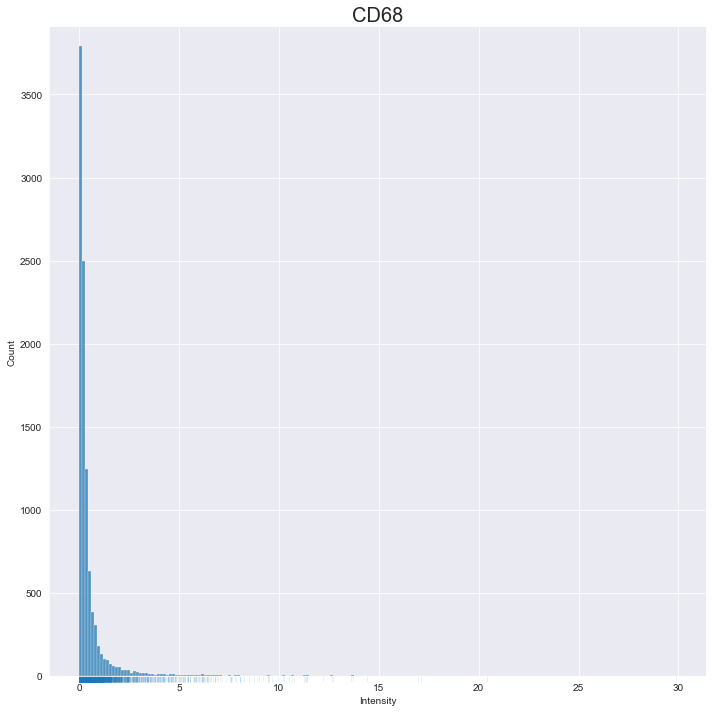

In [8]:
%%time
# Plot a distribution of the marker intensity across all images
plot_marker_intensity(all_data,  marker,
                      out=[abspath("./out/mets-density_CD68-raw.pdf"),
                           abspath("./out/mets-density_CD68-raw.png")])

In [8]:
# Trying to get a cutoff value for CD68 positive cells
cutoff = np.percentile(all_data, q=95)
cutoff

1.756449425220487

CPU times: total: 2.28 s
Wall time: 2.32 s


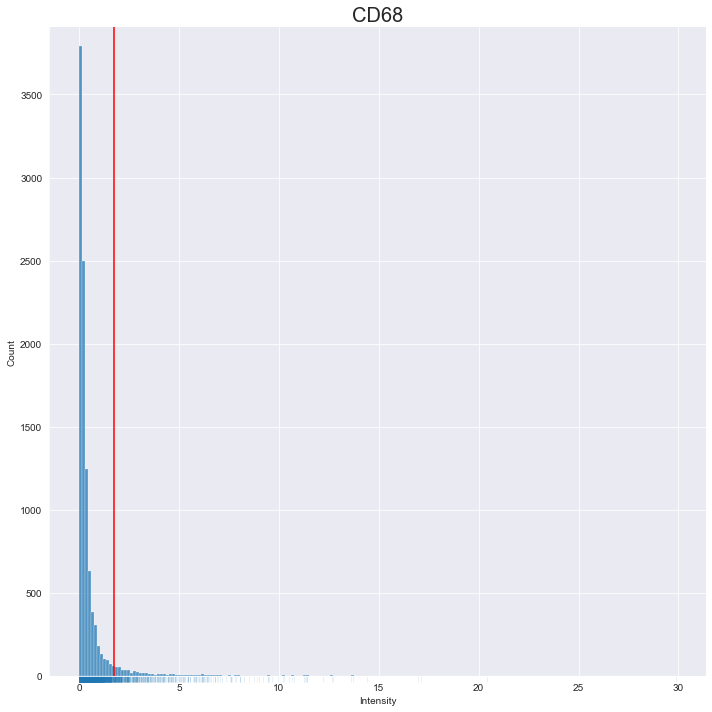

In [10]:
%%time
# show cutoff value
plot_marker_intensity(all_data, marker, cutoff,
                      out=[abspath("./out/mets-density_CD68-raw-gated.pdf"),
                           abspath("./out/mets-density_CD68-raw-gated.png")])

In [9]:
%%time
# Get log data and visualize
all_data_log = np.log(all_data)
all_data_log = all_data_log[~np.isinf(all_data_log)]

CPU times: total: 125 ms
Wall time: 139 ms


C:\Users\darkg\PycharmProjects\sandbox\venv\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


CPU times: total: 2.61 s
Wall time: 2.59 s


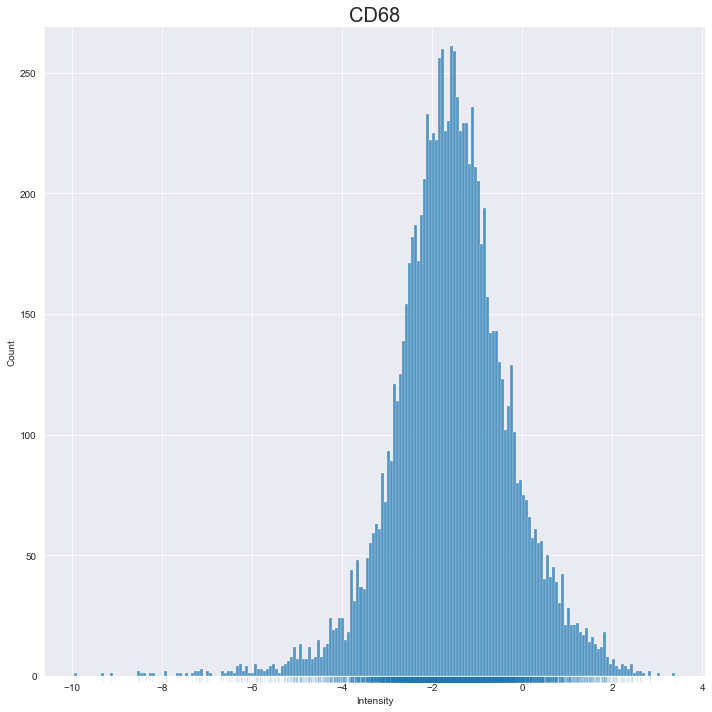

In [12]:
%%time
# Log data
plot_marker_intensity(all_data_log,  marker,
                      out=[abspath("./out/mets-density_CD68-log.pdf"),
                           abspath("./out/mets-density_CD68-log.png")])

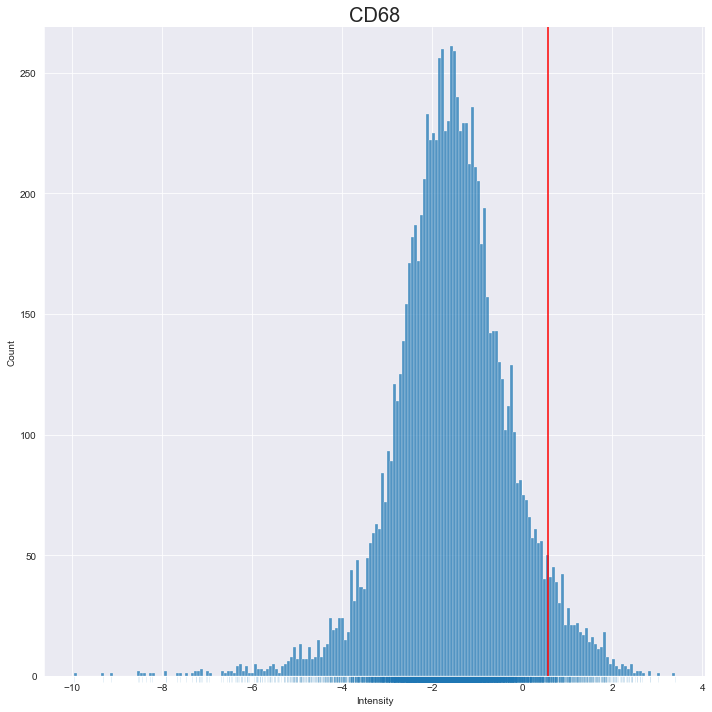

In [13]:
plot_marker_intensity(all_data_log,  marker, np.log(cutoff),
                      out=[abspath("./out/mets-density_CD68-log-gated.pdf"),
                           abspath("./out/mets-density_CD68-log-gated.png")])

## Plot intensity distribution by tissue

In [10]:
%%time
all_images = read_markers_labeled(folder_path, marker, metadata[["tissue", "sample"]])
all_images = all_images.sort_values(by="tissue", ascending=False)
all_images.head()

CPU times: total: 48.2 s
Wall time: 12.3 s


,CD68,tissue,sample
8941674,1.411798,MBM,N-2020-845_Restain_hBN220216
6548882,2.333575,MBM,N-2017-1414-1_Restain_hBN220216
6548893,1.278652,MBM,N-2017-1414-1_Restain_hBN220216
6548892,0.995881,MBM,N-2017-1414-1_Restain_hBN220216
6548891,2.150162,MBM,N-2017-1414-1_Restain_hBN220216


In [11]:
%%time
# Log scale the data
scaled = np.log(all_images[marker])
scaled = pd.DataFrame(scaled, columns=[marker])
scaled = scaled[~np.isinf(scaled[marker])]
scaled["tissue"] = all_images["tissue"]
scaled["sample"] = all_images["sample"]
scaled = scaled.sort_values(by="tissue", ascending=False)
scaled.head()

C:\Users\darkg\PycharmProjects\sandbox\venv\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: total: 7.47 s
Wall time: 7.75 s


,CD68,tissue,sample
8941674,0.344864,MBM,N-2020-845_Restain_hBN220216
8940223,0.017061,MBM,N-2020-845_Restain_hBN220216
8941383,-1.640002,MBM,N-2020-845_Restain_hBN220216
8941382,0.552166,MBM,N-2020-845_Restain_hBN220216
8941381,0.266300,MBM,N-2020-845_Restain_hBN220216


CPU times: total: 1min 12s
Wall time: 1min 16s


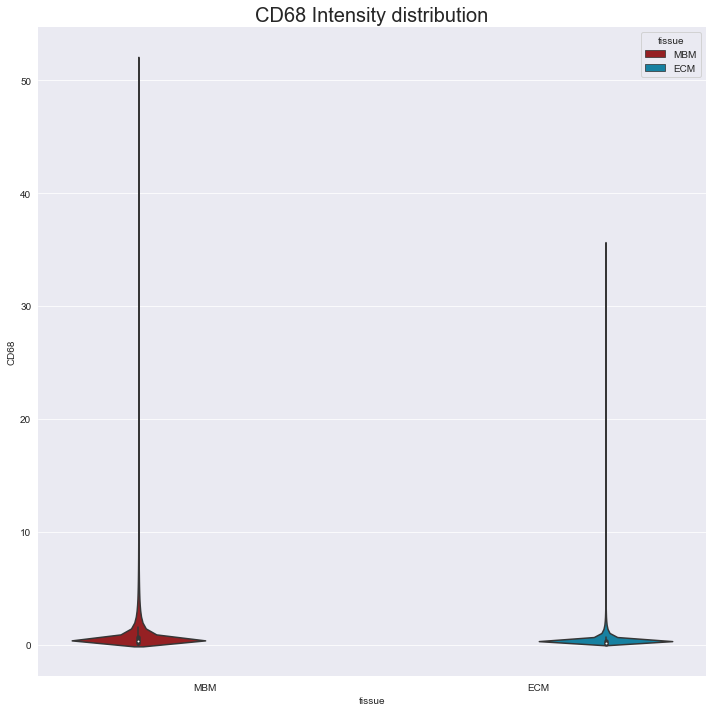

In [16]:
%%time
# Plot intensity distribution by tissue
plot_distributions(all_images, marker, hue="tissue", palette=palette,
                            out=[abspath("./out/mets-violin_cd68-color_MBM_ECM-raw.pdf"),
                                 abspath("./out/mets-violin_cd68-color_MBM_ECM-raw.png")])

CPU times: total: 55.2 s
Wall time: 55.4 s


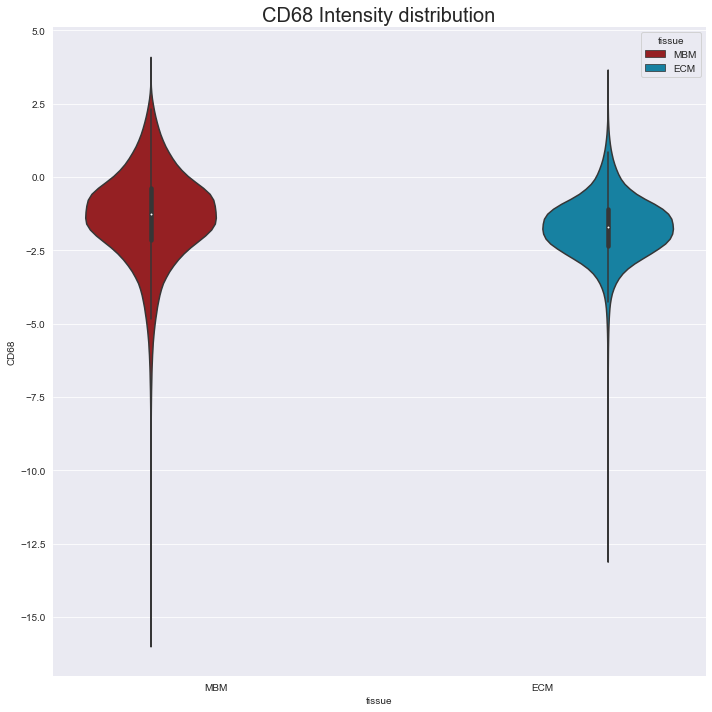

In [17]:
%%time
# Plot intensity distribution by tissue
plot_distributions(scaled, marker, hue="tissue", palette=palette,
                            out=[abspath("./out/mets-violin_cd68-color_MBM_ECM-log.pdf"),
                                 abspath("./out/mets-violin_cd68-color_MBM_ECM-log.png")])

## Visualize and check if threshold makes sense

In [18]:
%%time
# Visualize threshold
plot_centroids(image_quants_path, marker, cutoff,
               out=abspath(f"./out/{basename(image_raw_path)}.html"))

CPU times: total: 4.11 s
Wall time: 1.26 s


## Get CD68 mean marker intensities

In [12]:
%%time
metadata["CD68_intensity"] = get_marker_intensities(folder_path, marker, cutoff=0)
metadata.head()

CPU times: total: 37.8 s
Wall time: 5.18 s


,sample,source,n,tissue,CD68_intensity
file,,,,,
mesmer-N-2017-1885-1_hBN220215_18999-57405_cell.csv,N-2017-1885-1_hBN220215,brain,18147,MBM,0.027376
mesmer-N-2016-671-1_hBN220215_12114-54527_cell.csv,N-2016-671-1_hBN220215,brain,16726,MBM,0.219081
mesmer-N-2011-15-1_Restain_hBN220216_5580-43693_cell.csv,N-2011-15-1_Restain_hBN220216,brain,16689,MBM,0.196767
mesmer-N-2017-666-1_hBN220215_14872-44785_cell.csv,N-2017-666-1_hBN220215,brain,45474,MBM,0.822608
mesmer-N-2018-693_Restain_hBN220216_12057-35223_cell.csv,N-2018-693_Restain_hBN220216,brain,13070,MBM,0.939134


## Get CD68+ mean intensities

In [13]:
%%time
metadata["CD68+ Intensity"] = get_marker_intensities(folder_path, marker, cutoff=cutoff)
metadata.head()

CPU times: total: 36 s
Wall time: 4.74 s


,sample,source,n,tissue,CD68_intensity,CD68+ Intensity
file,,,,,,
mesmer-N-2017-1885-1_hBN220215_18999-57405_cell.csv,N-2017-1885-1_hBN220215,brain,18147,MBM,0.027376,3.420286
mesmer-N-2016-671-1_hBN220215_12114-54527_cell.csv,N-2016-671-1_hBN220215,brain,16726,MBM,0.219081,2.430599
mesmer-N-2011-15-1_Restain_hBN220216_5580-43693_cell.csv,N-2011-15-1_Restain_hBN220216,brain,16689,MBM,0.196767,3.887025
mesmer-N-2017-666-1_hBN220215_14872-44785_cell.csv,N-2017-666-1_hBN220215,brain,45474,MBM,0.822608,4.324548
mesmer-N-2018-693_Restain_hBN220216_12057-35223_cell.csv,N-2018-693_Restain_hBN220216,brain,13070,MBM,0.939134,3.214263


## Get marker positive cells

In [20]:
%%time
metadata["CD68_cells"] = get_marker_positive_cells(folder_path, marker, cutoff)
metadata.head()

CPU times: total: 36.2 s
Wall time: 5.42 s


,sample,source,n,tissue,CD68_intensity,CD68_cells
file,,,,,,
mesmer-N-2017-1885-1_hBN220215_18999-57405_cell.csv,N-2017-1885-1_hBN220215,brain,18147,MBM,0.027376,5
mesmer-N-2016-671-1_hBN220215_12114-54527_cell.csv,N-2016-671-1_hBN220215,brain,16726,MBM,0.219081,189
mesmer-N-2011-15-1_Restain_hBN220216_5580-43693_cell.csv,N-2011-15-1_Restain_hBN220216,brain,16689,MBM,0.196767,396
mesmer-N-2017-666-1_hBN220215_14872-44785_cell.csv,N-2017-666-1_hBN220215,brain,45474,MBM,0.822608,5046
mesmer-N-2018-693_Restain_hBN220216_12057-35223_cell.csv,N-2018-693_Restain_hBN220216,brain,13070,MBM,0.939134,1128


## Get proportion of marker positive cells

In [21]:
%%time
metadata["CD68_cell_proportion"] = metadata["CD68_cells"]/metadata["n"]
metadata.head()

CPU times: total: 0 ns
Wall time: 1.1 ms


,sample,source,n,tissue,CD68_intensity,CD68_cells,CD68_cell_proportion
file,,,,,,,
mesmer-N-2017-1885-1_hBN220215_18999-57405_cell.csv,N-2017-1885-1_hBN220215,brain,18147,MBM,0.027376,5,0.000276
mesmer-N-2016-671-1_hBN220215_12114-54527_cell.csv,N-2016-671-1_hBN220215,brain,16726,MBM,0.219081,189,0.011300
mesmer-N-2011-15-1_Restain_hBN220216_5580-43693_cell.csv,N-2011-15-1_Restain_hBN220216,brain,16689,MBM,0.196767,396,0.023728
mesmer-N-2017-666-1_hBN220215_14872-44785_cell.csv,N-2017-666-1_hBN220215,brain,45474,MBM,0.822608,5046,0.110965
mesmer-N-2018-693_Restain_hBN220216_12057-35223_cell.csv,N-2018-693_Restain_hBN220216,brain,13070,MBM,0.939134,1128,0.086305


## Plot Marker Intensity for CD68

CPU times: total: 688 ms
Wall time: 710 ms


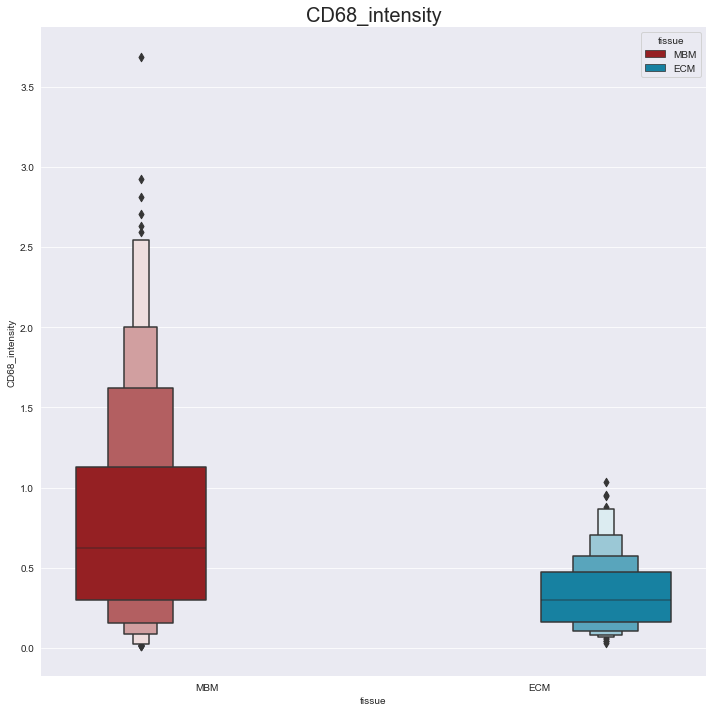

In [24]:
%%time
plot_distribution_boxen(metadata, "CD68_intensity", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-cd68_mean_intensity.pdf"),
                             abspath("./out/mets-boxen-cd68_mean_intensity.png")])

CPU times: total: 1.86 s
Wall time: 2.04 s


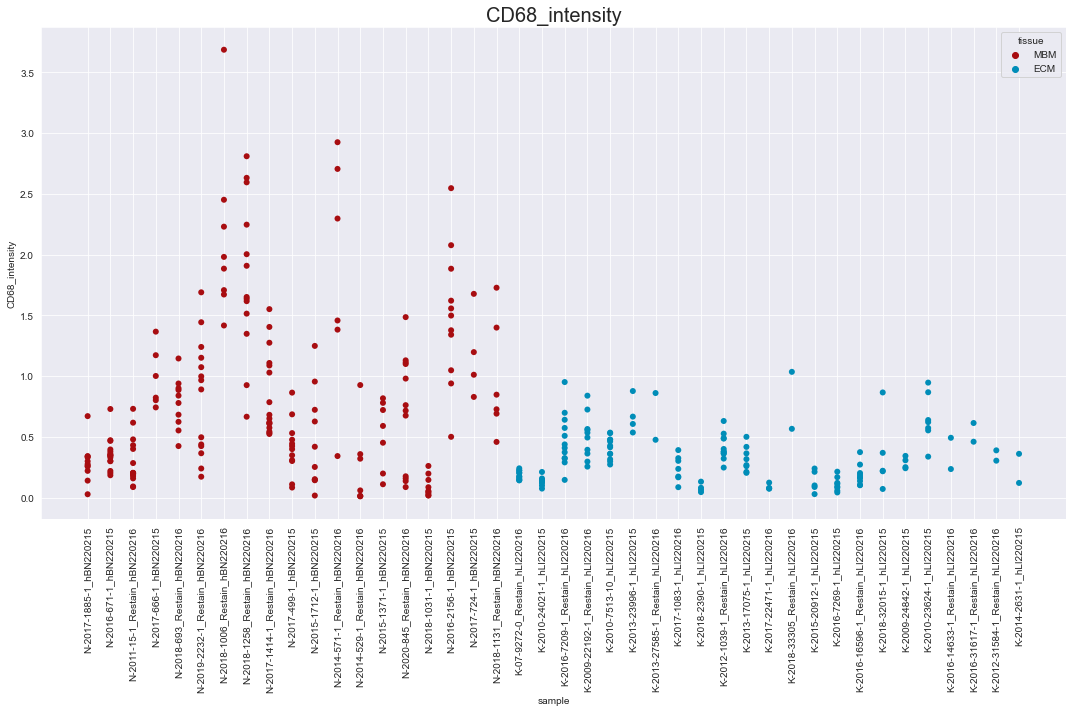

In [32]:
%%time
plot_sample_distributions(metadata, x="sample", marker="CD68_intensity", hue="tissue", palette=palette,
                          out=[abspath("./out/mets-scatter-cd68_mean_intensity_per_sample.pdf"),
                               abspath("./out/mets-scatter-cd68_mean_intensity_per_sample.png")])

## Plot Marker Intensity for CD68+ cells

CPU times: total: 922 ms
Wall time: 1.01 s


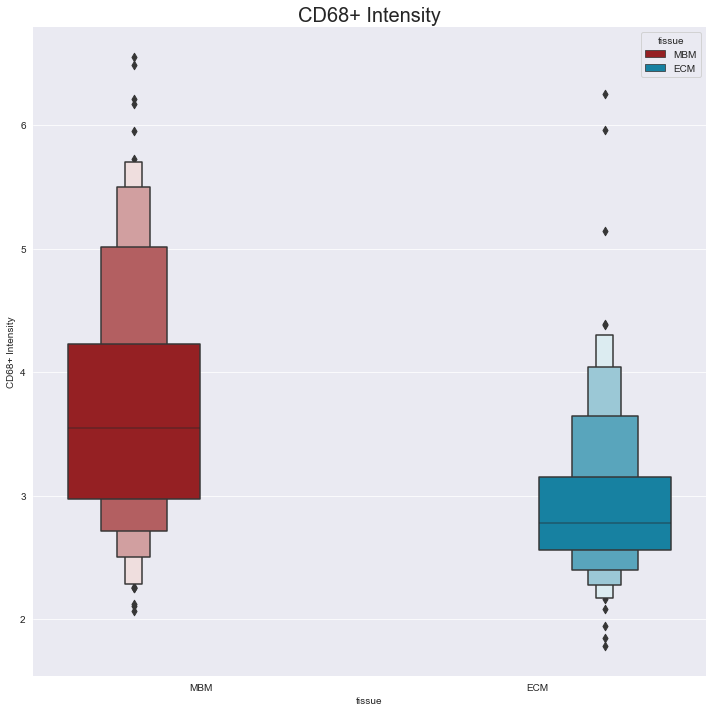

In [14]:
%%time
plot_distribution_boxen(metadata, "CD68+ Intensity", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-CD68pos_mean_intensity.pdf"),
                             abspath("./out/mets-boxen-CD68pos_mean_intensity.png")])

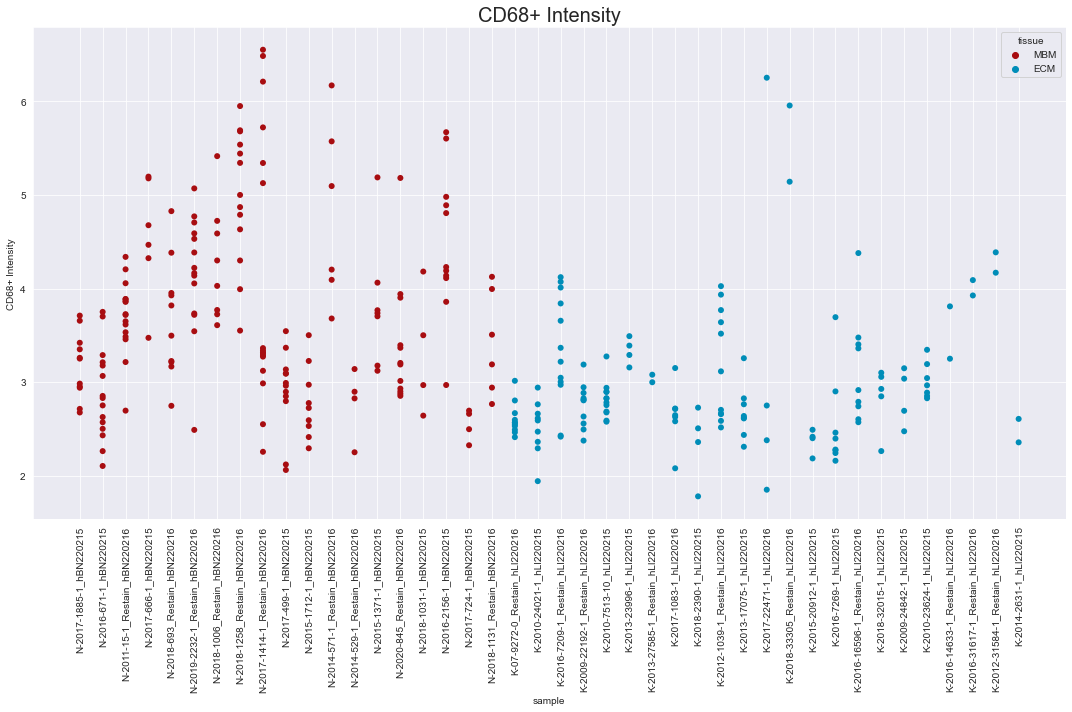

In [15]:
plot_sample_distributions(metadata, x="sample", marker="CD68+ Intensity", hue="tissue", palette=palette,
                          out=[abspath("./out/mets-scatter-CD68pos_mean_intensity_per_sample.pdf"),
                               abspath("./out/mets-scatter-CD68pos_mean_intensity_per_sample.png")])

## Number of CD68 positive cells

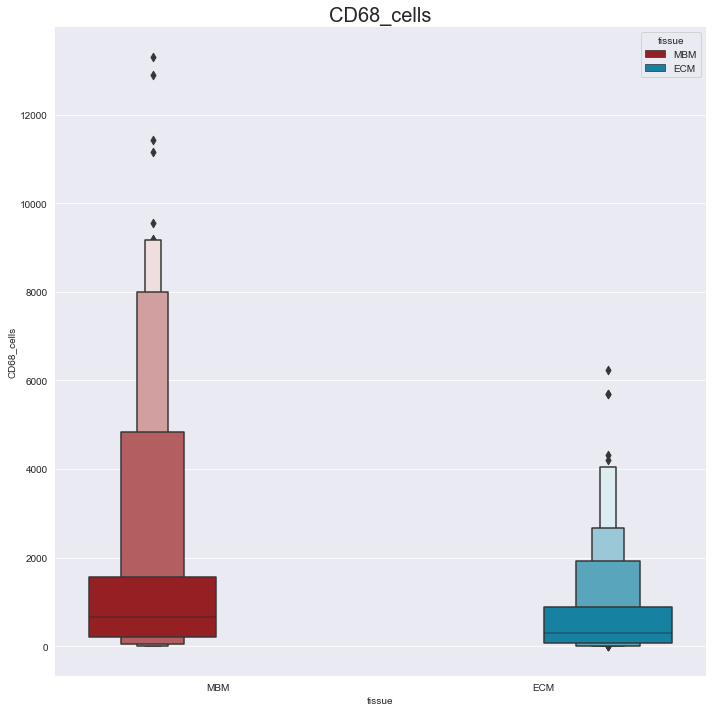

In [33]:
plot_distribution_boxen(metadata, marker="CD68_cells", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-cd68_cells.pdf"),
                             abspath("./out/mets-boxen-cd68_cells.png")])

CPU times: total: 1.95 s
Wall time: 2.05 s


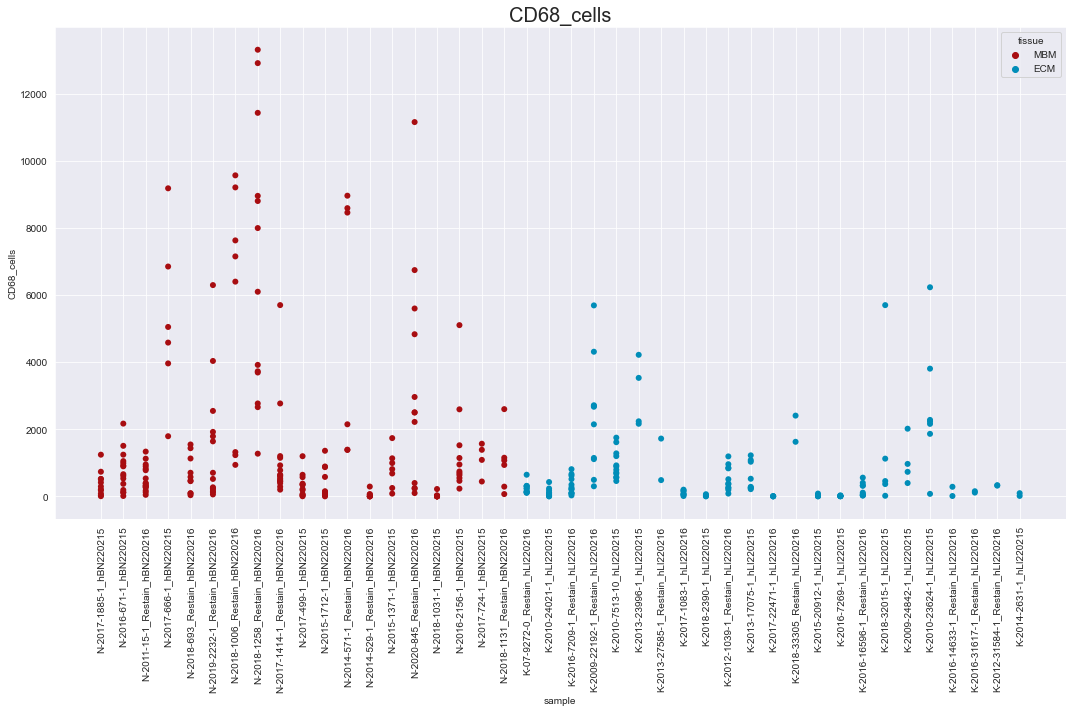

In [34]:
%%time
# Plot CD68  positve cells per sample
plot_sample_distributions(metadata, x="sample", marker="CD68_cells", hue="tissue", palette=palette,
                          out=[abspath("./out/mets-scatter-cd68_cells_per_sample.pdf"),
                               abspath("./out/mets-scatter-cd68_cells_per_sample.png")])

## Proportion of CD68 positive cells

CPU times: total: 828 ms
Wall time: 845 ms


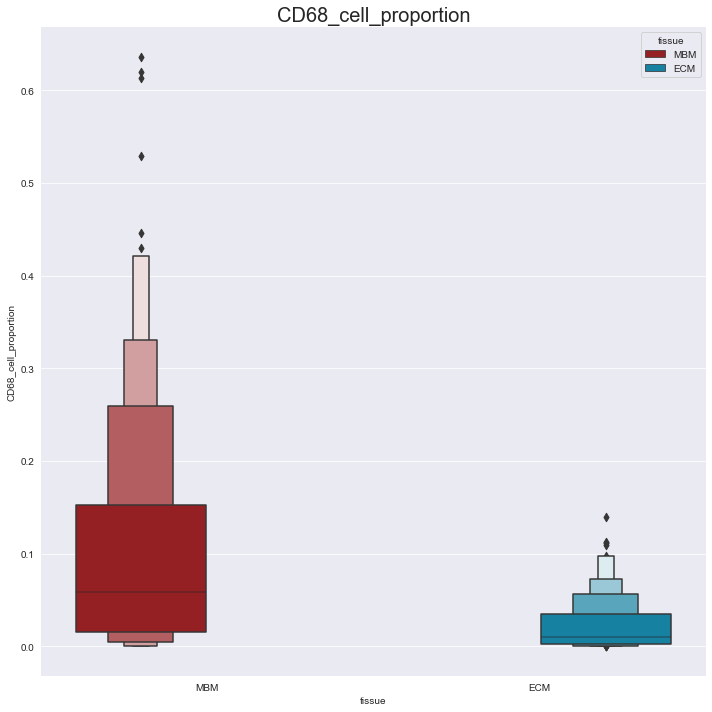

In [35]:
%%time
# Plot CD68 positve cells per tissue
plot_distribution_boxen(metadata, marker="CD68_cell_proportion", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-cd68_proportion.pdf"),
                             abspath("./out/mets-boxen-cd68_proportion.png")])

CPU times: total: 1.91 s
Wall time: 1.99 s


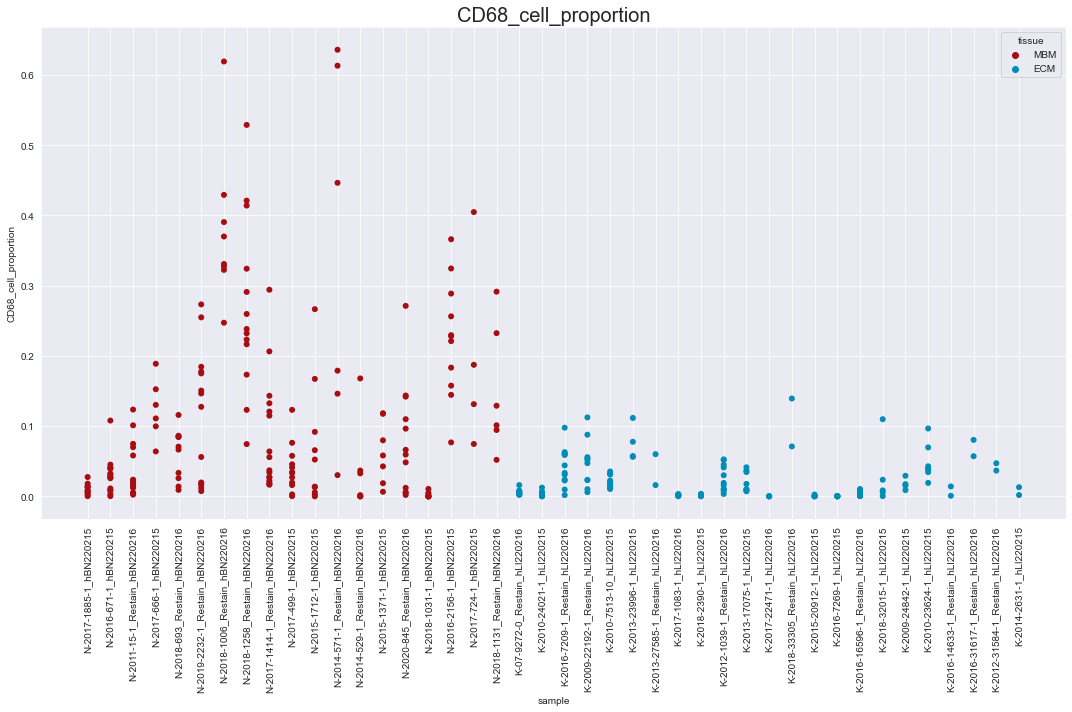

In [36]:
%%time
# Plot CD68 cell proportion per sample
plot_sample_distributions(metadata, x="sample", marker="CD68_cell_proportion", hue="tissue", palette=palette,
                          out=[abspath("./out/mets-scatter-cd68_cells_proportion_per_sample.pdf"),
                               abspath("./out/mets-scatter-cd68_cells_proportion_per_sample.png")])

## Create interative figure

In [188]:
%%time
# Read in raw image and mask
image_raw = io.imread(image_raw_path)
image_mask = io.imread(image_mask_path)
image_quants = dt.fread(image_quants_path, columns={"CellID":"CellID", marker:marker, "X_centroid":"X", "Y_centroid":"Y", ...:None}).to_pandas()

plot_cell_contours_plotly(image_raw, image_mask, image_quants, out=abspath("../out/cd68_mask_test.html"), marker=marker, cutoff=cutoff, channel=2)

CPU times: total: 13min 59s
Wall time: 14min 3s


## Stats for number of cells

In [31]:
# Wilcoxon-Ranksum test to check the difference between the amount of cells on MBM vs ECM tissue
res = ranksums(metadata[metadata["tissue"]=="MBM"]["CD68_cells"], metadata[metadata["tissue"]=="ECM"]["CD68_cells"])
res

RanksumsResult(statistic=4.219200075118699, pvalue=2.451706339407188e-05)

In [39]:
for g, d in metadata.groupby("tissue"):
    print(f"Mean {marker} positve cells per image in {g} = {d['CD68_cells'].mean()}")
    print(f"STD {marker} positve cells per image in {g} = {d['CD68_cells'].mean()}")

Mean CD68 positve cells per image in ECM = 747.2676056338029
STD CD68 positve cells per image in ECM = 747.2676056338029
Mean CD68 positve cells per image in MBM = 1766.6943005181347
STD CD68 positve cells per image in MBM = 1766.6943005181347


## Stats for cell proportion

In [32]:
# Wilcoxon-Ranksum test to check the difference between the proportion of cells on MBM vs ECM tissue
res_prop =  ranksums(metadata[metadata["tissue"]=="MBM"]["CD68_cell_proportion"], metadata[metadata["tissue"]=="ECM"]["CD68_cell_proportion"])
res_prop

RanksumsResult(statistic=7.762026761571859, pvalue=8.3582762653931e-15)

In [41]:
# Get mean and std  by tissue for CD68 cell proportion
for g, d in metadata.groupby("tissue"):
    print(f"Mean {marker} cell proportion per image in {g} = {d['CD68_cell_proportion'].mean():.4f}")
    print(f"STD {marker} cell proportion per image in {g} = {d['CD68_cell_proportion'].mean():.4f}")

Mean CD68 cell proportion per image in ECM = 0.0228
STD CD68 cell proportion per image in ECM = 0.0228
Mean CD68 cell proportion per image in MBM = 0.1090
STD CD68 cell proportion per image in MBM = 0.1090


## Stats for Intensity

### Wilcoxon ransum test for raw intensity

In [36]:
%%time
res_int = ranksums(all_images[all_images["tissue"]=="MBM"][marker], all_images[all_images["tissue"]=="ECM"][marker])
res_int

CPU times: total: 4.12 s
Wall time: 4.34 s


RanksumsResult(statistic=521.3614598763215, pvalue=0.0)

In [42]:
for g, d in all_images.groupby("tissue"):
    print(f"Mean intensity of {marker} cells in {g} = {d[marker].mean():.4f}")
    print(f"STD  intensity of {marker} cells in {g} = {d[marker].std():.4f}")

Mean intensity of CD68 cells in ECM = 0.3195
STD  intensity of CD68 cells in ECM = 0.5480
Mean intensity of CD68 cells in MBM = 0.7442
STD  intensity of CD68 cells in MBM = 1.5380


In [21]:
CD68pos = all_images[all_images[marker] >= cutoff]
res_int_CD68pos = ranksums(CD68pos[CD68pos["tissue"]=="MBM"][marker], CD68pos[CD68pos["tissue"]=="ECM"][marker])
res_int_CD68pos

RanksumsResult(statistic=114.39243120465107, pvalue=0.0)

In [40]:
# Calculate fold change
np.log2(0.7442/0.3195)

1.2198744592914157

### Wilcoxon ranksum test for mean intensity on CD68 marker

In [308]:
%%time
res_mean_int = ranksums(metadata[metadata["tissue"]=="MBM"]["CD68_intensity"], metadata[metadata["tissue"]=="ECM"]["CD68_intensity"])
res_mean_int

CPU times: total: 15.6 ms
Wall time: 4.99 ms


RanksumsResult(statistic=6.837935186677761, pvalue=8.034272832108145e-12)

### Wilcoxon ranksum test for mean intensity on CD68+ cells

In [16]:
res_mean_int_CD68pos = ranksums(metadata[metadata["tissue"]=="MBM"]["CD68+ Intensity"], metadata[metadata["tissue"]=="ECM"]["CD68+ Intensity"])
res_mean_int_CD68pos

RanksumsResult(statistic=8.511459891797895, pvalue=1.7175694461566358e-17)